In [1]:
import os
os.environ['THEANO_FLAGS']='mode=FAST_RUN, floatX=float32'
#os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=gpu,floatX=float32'
# This gives a 'perform' error in compile
#os.environ['THEANO_FLAGS']='mode=FAST_COMPILE,device=gpu1,floatX=float32'
#os.environ['THEANO_FLAGS']='device=gpu0'

In [2]:
import theano
print theano.config.device

cpu


In [3]:
from __future__ import absolute_import
from __future__ import print_function
import pylab as pl
import matplotlib.cm as cm
import numpy as np
np.random.seed(1337) # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils


Using Theano backend.


'\n    Train a simple convnet on the MNIST dataset.\n\n    Run on GPU: THEANO_FLAGS=mode=FAST_RUN,device=gpu,floatX=float32 python mnist_cnn.py\n\n    Get to 99.25% test accuracy after 12 epochs (there is still a lot of margin for parameter tuning).\n    16 seconds per epoch on a GRID K520 GPU.\n'

In [4]:
np.set_printoptions(precision=5, suppress=True)

In [5]:
%matplotlib inline

In [6]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


label :  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


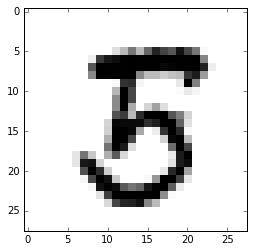

In [7]:
i = 4600
pl.imshow(X_train[i, 0], interpolation='nearest', cmap=cm.binary)
print("label : ", Y_train[i,:])

In [8]:
# input image dimensions
#img_rows, img_cols = 28, 28

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(1, img_rows, img_cols)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [9]:
WEIGHTS_FNAME = 'mnist_cnn_weights.hdf'
if True and os.path.exists(WEIGHTS_FNAME):
    # Just change the True to false to force re-training
    print('Loading existing weights')
    model.load_weights(WEIGHTS_FNAME)
else:
    batch_size = 128
    nb_epoch = 12
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              show_accuracy=True, verbose=1, validation_data=(X_test, Y_test))
    model.save_weights(WEIGHTS_FNAME)
score = model.evaluate(X_test, Y_test, show_accuracy=True, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

    

Loading existing weights
Test score: 0.0317075505275
Test accuracy: 0.9916


In [10]:
print(model.predict(X_test[1:5]))
print(Y_test[1:5])

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [11]:
Y_pred = model.predict(X_test)
# Convert one-hot to index
y_pred = np.argmax(Y_pred, axis=1)

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       980
          1       0.99      1.00      1.00      1135
          2       0.99      0.99      0.99      1032
          3       0.99      1.00      1.00      1010
          4       0.99      0.99      0.99       982
          5       0.99      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.98      0.99      1009

avg / total       0.99      0.99      0.99     10000



## Convolution visualizations

In [13]:
convout1_f = theano.function([model.get_input(train=False)], convout1.get_output(train=False))
#convout2_f = theano.function([model.get_input(train=False)], convout2.get_output(train=False))

In [14]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)

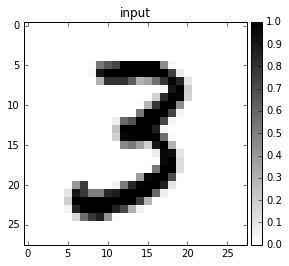

In [15]:
i = 4600

# Visualize the first layer of convolutions on an input image
X = X_test[i:i+1]

pl.figure()
pl.title('input')
nice_imshow(pl.gca(), np.squeeze(X), vmin=0, vmax=1, cmap=cm.binary)

In [16]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

#pl.imshow(make_mosaic(np.random.random((9, 10, 10)), 3, 3, border=1))

W shape :  (32, 3, 3)


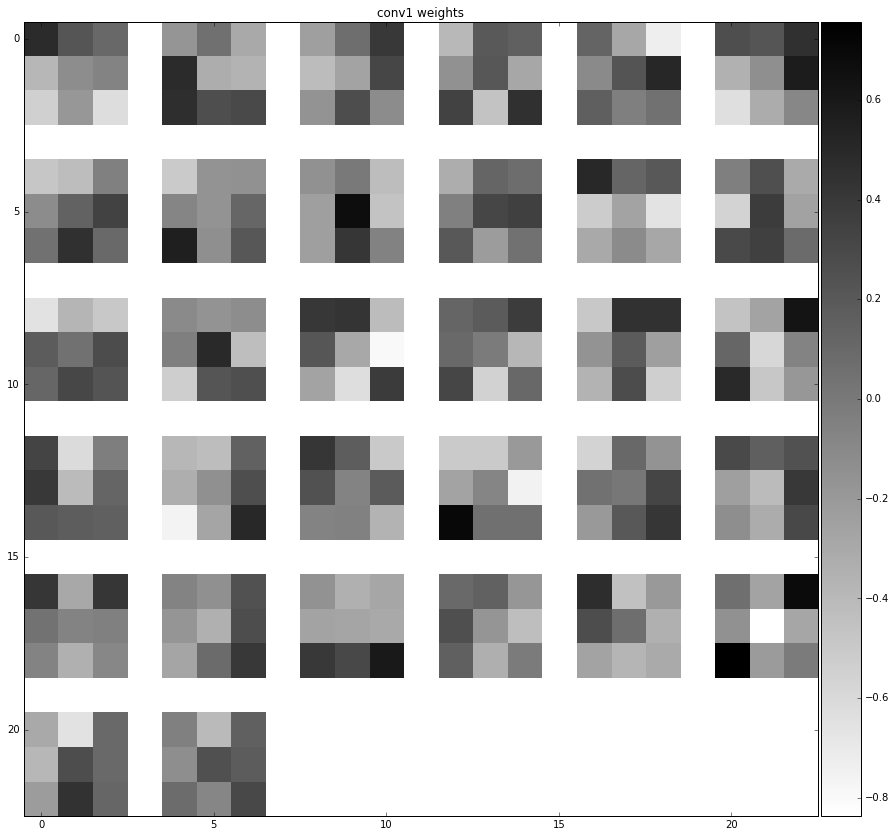

In [17]:
# Visualize weights
W = model.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)
print("W shape : ", W.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W, 6, 6), cmap=cm.binary)

C1 shape :  (32, 26, 26)


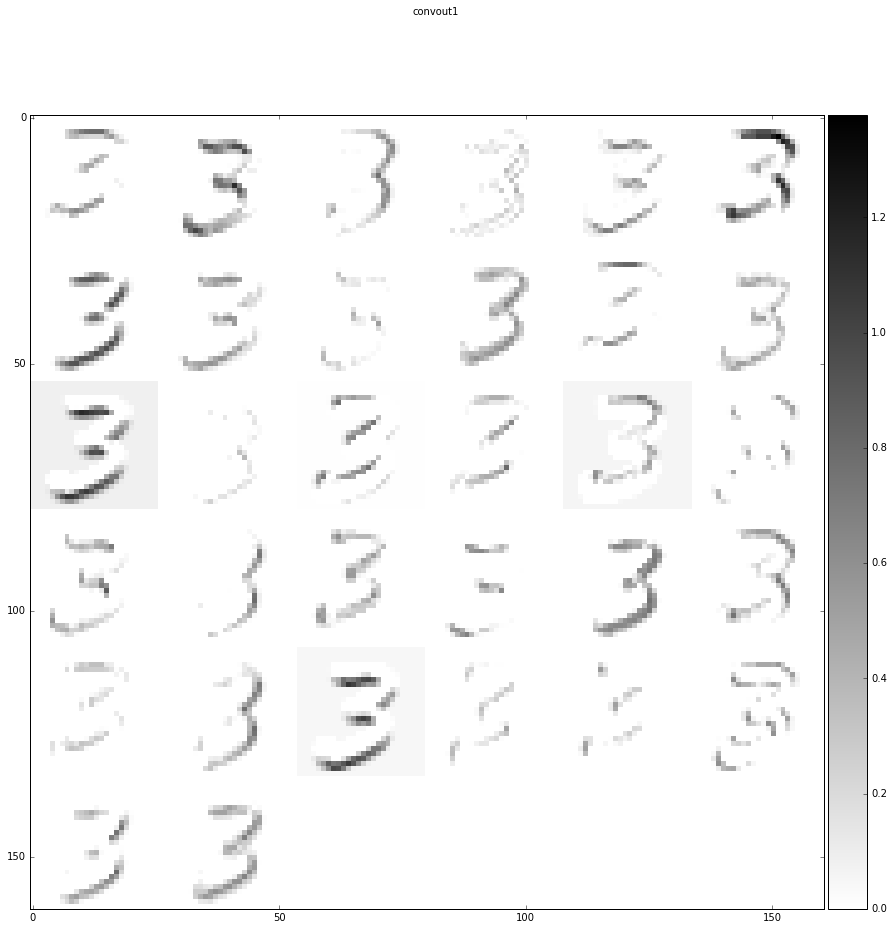

In [18]:
# Visualize convolution result (after activation)
C1 = convout1_f(X)
C1 = np.squeeze(C1)
print("C1 shape : ", C1.shape)

pl.figure(figsize=(15, 15))
pl.suptitle('convout1')
nice_imshow(pl.gca(), make_mosaic(C1, 6, 6), cmap=cm.binary)